# Ad Recommendation System - Group 3 - Final Project

### SYSTEM TO FIND THE MOST RELEVANT PUBLISHER WEBPAGES FOR THE GIVEN SET OF ADVERTISER ADS

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import nltk
#nltk.download()
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/shivd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/shivd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shivd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/shivd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Loading datasets

In [3]:
# importing the ads dataset
ads_data = pd.read_csv('inputfiles/collected_sports_data.csv')
ads_data = ads_data.dropna(axis=1)


# importing the content dataset
# content_data = pd.read_csv('inputfiles/Videos_data.csv')
content_data = pd.read_csv('inputfiles/content_data.csv')



# # Import Data
# vdata = pd.read_csv(‘Videos_data.csv’)
# vdata = data.iloc[:, 1:] # Remove extra un-named column
# vdata.head(10)


# #import data
# adata = pd.read_csv(‘collected_sports_data.csv’ )
# adata.head(10)

In [4]:
ads_data.head(3)

,Original Url,Title 1,Meta Description 1,H1-1
0,https://www.adforum.com/creative-work/ad/playe...,"Leos - ""Inner Beauty""","Television Inner Beauty for Leos by Xynias, We...","Leos - ""Inner Beauty"""
1,https://www.adforum.com/creative-work/ad/playe...,"Ninemsn - ""Indian Restaurant""",Television Indian Restaurant for Ninemsn by Ha...,"Ninemsn - ""Indian Restaurant"""
2,https://www.adforum.com/creative-work/ad/playe...,"Social Democratic Party - ""Social-Democratic P...",Television Social-Democratic Party for Social ...,"Social Democratic Party - ""Social-Democratic P..."


In [5]:
content_data.head(3)

,Page Id,Title,Description,Category
0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel


In [6]:
content_data['Category'].unique()

array(['travel', 'science and technology', 'food', 'manufacturing',
       'history', 'art and music'], dtype=object)

#### Data pre-processing and cleaning

In [7]:
lem = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_and_clean(text):
    #lower case the content
    text = text.lower()
    
    # remove the numbers
    text = re.sub(r'\d+', '', text)
    
    # remove punctuations
    text = text.translate(text.maketrans('','',string.punctuation))
    
    # remove trailing white spaces
    text = text.strip()
    
    # tokenize into words
    text = word_tokenize(text)
    
    #remove non alphabetic tokens
    text = [word for word in text if word.isalpha()]
    
    # filter out stopwords
    text = [word for word in text if not word in stop_words]
    
    # Word Lemmatization
    text = [lem.lemmatize(word,"v") for word in text]
    
    # joining back the words
    text = ' '.join(text)
    
    return text

In [8]:
ads_data['Title 1'] = ads_data['Title 1'].apply(lambda x: preprocess_and_clean(x))

In [9]:
content_data['Title'] = content_data['Title'].apply(lambda x:preprocess_and_clean(x))

#### Label encoding the classes

In [10]:
content_data.head(3)

,Page Id,Title,Description,Category
0,ehmsJLZlCZ0,ep travel north east india arunachal journey b...,"The journey to Arunachal, North East India beg...",travel
1,e2NQE41J5eM,travel much earn money,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,i9E_Blai8vk,travel vlog welcome bali priscilla lee,I had the chance to fly out to Bali with my wh...,travel


In [11]:
le = LabelEncoder()
le.fit(content_data.Category)
content_data.Category = le.transform(content_data.Category)
content_data.head(3)

,Page Id,Title,Description,Category
0,ehmsJLZlCZ0,ep travel north east india arunachal journey b...,"The journey to Arunachal, North East India beg...",5
1,e2NQE41J5eM,travel much earn money,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,5
2,i9E_Blai8vk,travel vlog welcome bali priscilla lee,I had the chance to fly out to Bali with my wh...,5


In [12]:
content_data.Category.unique()

array([5, 4, 1, 3, 2, 0])

#### Analyzing number of samples for each class

<AxesSubplot: title={'center': 'Number of samples for each class'}>

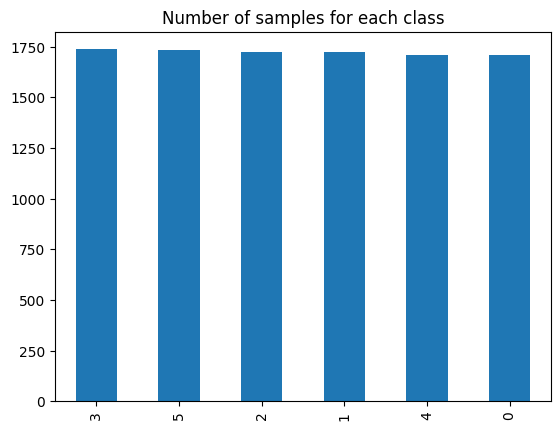

In [13]:
content_data['Category'].value_counts().sort_values(ascending=False).plot(kind='bar', y='Number of Samples', 
                                                                title='Number of samples for each class')

#### Vectorizing text features using TF-IDF

In [14]:
# Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(
                            # smooth_idf=True, max_features=5,
                             sublinear_tf=True, 
                             min_df=5, norm='l2', encoding='latin-1', 
                             ngram_range=(1, 2), stop_words='english')

In [15]:
tfidf_title = vectorizer.fit_transform(content_data.Title).toarray()

In [16]:
words = vectorizer.get_feature_names_out()

In [17]:
tfidf_title.shape

(10333, 2708)

In [18]:
labels = content_data.Category

In [20]:
N = 5
for current_class in list(le.classes_):
    current_class_id = le.transform([current_class])[0]
    features_chi2 = chi2(tfidf_title, labels == current_class_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(current_class))
    print("Most correlated unigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(unigrams[-N:])))
    print("Most correlated bigrams:")
    print('-' *30)
    print('. {}'.format('\n. '.join(bigrams[-N:])))
    print("\n")

# 'art and music':
Most correlated unigrams:
------------------------------
. paint
. official
. music
. art
. theatre
Most correlated bigrams:
------------------------------
. capitol theatre
. musical theatre
. work theatre
. official music
. music video


# 'food':
Most correlated unigrams:
------------------------------
. foods
. eat
. snack
. cook
. food
Most correlated bigrams:
------------------------------
. healthy snack
. snack amp
. taste test
. kid try
. street food


# 'history':
Most correlated unigrams:
------------------------------
. discoveries
. archaeological
. archaeology
. history
. anthropology
Most correlated bigrams:
------------------------------
. history channel
. epic rap
. rap battle
. battle history
. archaeological discoveries


# 'manufacturing':
Most correlated unigrams:
------------------------------
. business
. printer
. process
. print
. manufacture
Most correlated bigrams:
------------------------------
. manufacture plant
. lean manufacture
. add

#### Modelling and Training

In [21]:
X_train, X_test, y_train, y_test = train_test_split(content_data[['Title']], content_data['Category'], random_state = 0)

In [22]:
X_train.shape, X_test.shape

((7749, 1), (2584, 1))

In [23]:
y_train.shape, y_test.shape

((7749,), (2584,))

In [24]:
X_train_tfidf_title = vectorizer.transform(X_train.Title).toarray()

In [25]:
X_train.head(3)

,Title
151,vienna trip gopro twotravelers travel amp life...
614,royalty free background music drone travel blo...
3750,cook thanksgiving food


In [26]:
y_train.head(3)

151     5
614     5
3750    1
Name: Category, dtype: int64

In [27]:
X_test_tfidf_title = vectorizer.transform(X_test.Title).toarray()

In [28]:
X_test.head(3)

,Title
3954,top gmo foods avoid
9082,naep arts art everywhere
6333,class geography manufacture industries iron


In [29]:
y_test.head(3)

3954    1
9082    0
6333    3
Name: Category, dtype: int64

##### Naive Bayes

In [30]:
nb = MultinomialNB().fit(X_train_tfidf_title, y_train)

##### SVM classifier

In [31]:
svm = linear_model.SGDClassifier(loss='modified_huber',max_iter=1000, tol=1e-3).fit(X_train_tfidf_title,y_train)

##### ADABoost

In [32]:
adaboost = AdaBoostClassifier(n_estimators=40,algorithm="SAMME").fit(X_train_tfidf_title,y_train)

#### Evaluating with Naive Bayes

In [33]:
X_test_tfidf_title = vectorizer.transform(X_test.Title).toarray()

In [34]:
y_pred = nb.predict(X_test_tfidf_title)
y_probas = nb.predict_proba(X_test_tfidf_title)


In [35]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=list(le.classes_)))

                        precision    recall  f1-score   support

         art and music       0.94      0.95      0.95       459
                  food       0.96      0.94      0.95       437
               history       0.96      0.95      0.96       447
         manufacturing       0.94      0.98      0.96       414
science and technology       0.94      0.94      0.94       413
                travel       0.96      0.93      0.95       414

              accuracy                           0.95      2584
             macro avg       0.95      0.95      0.95      2584
          weighted avg       0.95      0.95      0.95      2584



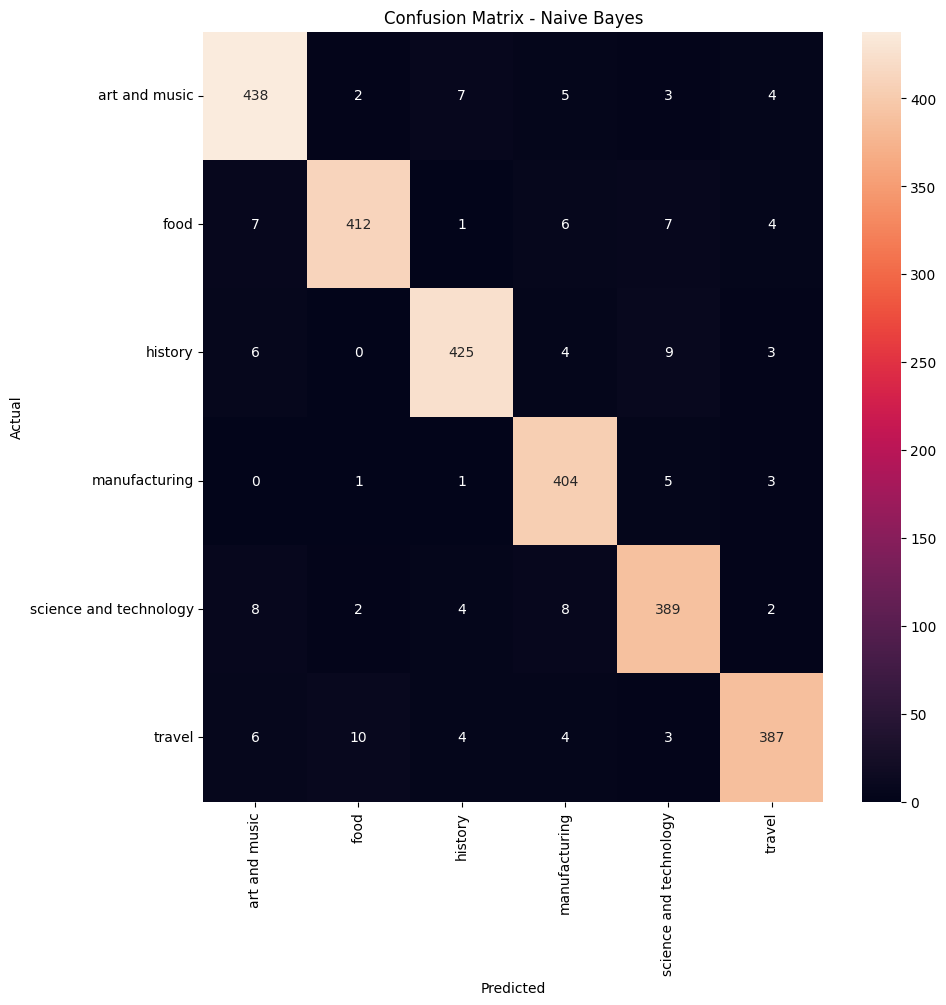

In [36]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# skplt.metrics.plot_precision_recall(y_test, y_probas)
# plt.title('Precision-Recall Curve - Naive Bayes')
# plt.show()

#### Evaluating with SVM

In [37]:
y_pred = svm.predict(X_test_tfidf_title)
y_probas = svm.predict_proba(X_test_tfidf_title)

                        precision    recall  f1-score   support

         art and music       0.99      0.97      0.98       459
                  food       0.99      0.98      0.98       437
               history       0.98      0.97      0.98       447
         manufacturing       0.99      0.99      0.99       414
science and technology       0.92      0.98      0.95       413
                travel       0.99      0.98      0.98       414

              accuracy                           0.98      2584
             macro avg       0.98      0.98      0.98      2584
          weighted avg       0.98      0.98      0.98      2584



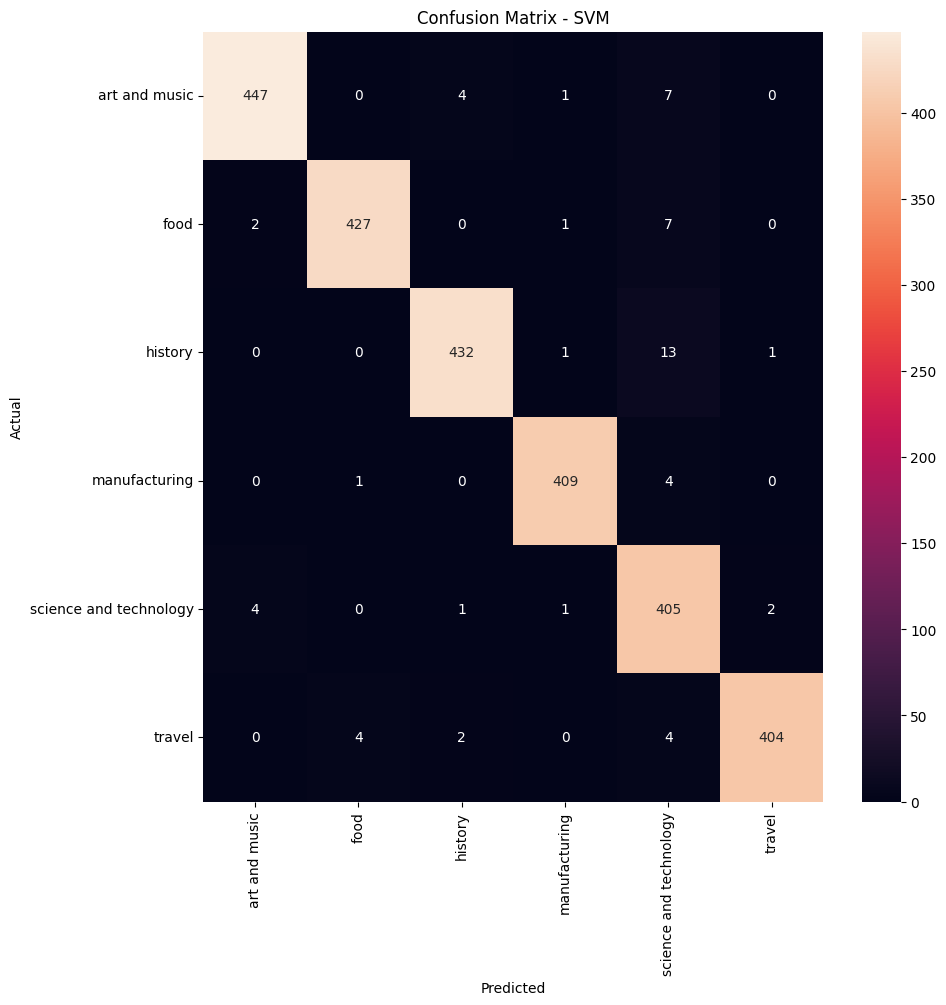

In [38]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=list(le.classes_)))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM')
plt.show()

# skplt.metrics.plot_precision_recall(y_test, y_probas)
# plt.title('Precision-Recall Curve - SVM')
# plt.show()

#### Evaluating with ADABooster

In [39]:
# Adaboost Classifier
y_pred = adaboost.predict(X_test_tfidf_title)
y_probas = adaboost.predict_proba(X_test_tfidf_title)

                        precision    recall  f1-score   support

         art and music       0.99      0.86      0.92       459
                  food       0.99      0.91      0.95       437
               history       0.58      0.99      0.73       447
         manufacturing       1.00      0.81      0.90       414
science and technology       0.98      0.74      0.85       413
                travel       0.99      0.88      0.93       414

              accuracy                           0.87      2584
             macro avg       0.92      0.87      0.88      2584
          weighted avg       0.92      0.87      0.88      2584



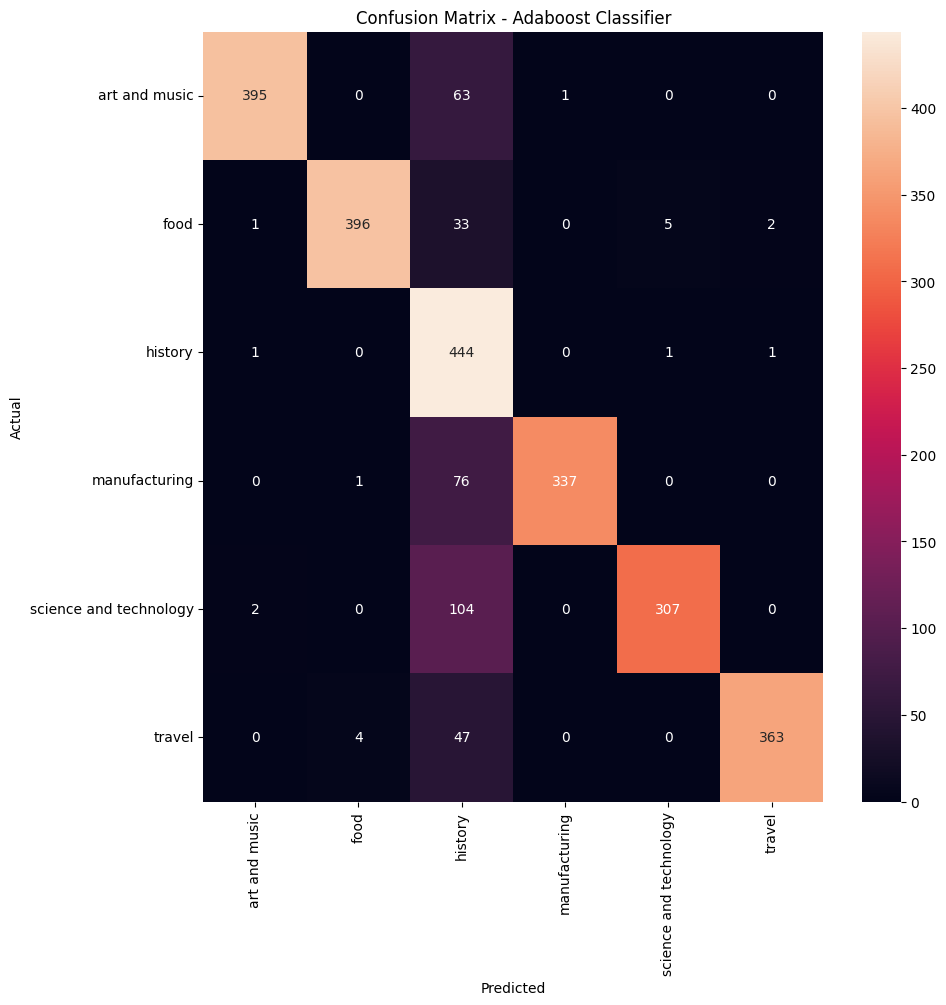

In [40]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=list(le.classes_)))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Adaboost Classifier')
plt.show()

# skplt.metrics.plot_precision_recall(y_test, y_probas)
# plt.title('Precision-Recall Curve - Adaboost Classifier')
# plt.show()

#### Ad recommender / Matching content with ads

In [41]:
ads_data.head(3)

,Original Url,Title 1,Meta Description 1,H1-1
0,https://www.adforum.com/creative-work/ad/playe...,leos inner beauty,"Television Inner Beauty for Leos by Xynias, We...","Leos - ""Inner Beauty"""
1,https://www.adforum.com/creative-work/ad/playe...,ninemsn indian restaurant,Television Indian Restaurant for Ninemsn by Ha...,"Ninemsn - ""Indian Restaurant"""
2,https://www.adforum.com/creative-work/ad/playe...,social democratic party socialdemocratic party,Television Social-Democratic Party for Social ...,"Social Democratic Party - ""Social-Democratic P..."


In [42]:
# Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(smooth_idf=True, max_features=50)

# Learn vocabulary and idf, return term-document matrix.
# tfidf = vectorizer.fit_transform(content_data.Title.values.astype('U'))
tfidf = vectorizer.fit_transform(content_data.Title).toarray()

# Array mapping from feature integer indices to feature name
words = vectorizer.get_feature_names_out()

# Compute cosine similarity between samples in X and Y.
similarity_matrix = cosine_similarity(tfidf, tfidf)

# Matrix product
print(similarity_matrix)

[[1.         0.46601515 0.22219392 ... 0.         0.         0.        ]
 [0.46601515 1.         0.47679548 ... 0.         0.         0.        ]
 [0.22219392 0.47679548 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         1.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         1.        ]]


In [43]:
df = pd.DataFrame()

loopcount = 0
for idx, adrow in ads_data.iterrows():
    # Instead of using fit_transform, you need to first fit 
    # the new document to the TFIDF matrix corpus like this:
    queryTFIDF = vectorizer.fit(words)

    # We can check that using a new document text
    ad_data = adrow['Title 1']
    # print(f'checking top webpages for the ad: {ad_data} having index: {idx}')

    # Now we can 'transform' this vector into that matrix shape by using the transform function:
    queryTFIDF = queryTFIDF.transform([ad_data]).toarray()

    # As we transformed our query in a tfidf object
    # we can calculate the cosine similarity in comparison with 
    # our pevious corpora
    cosine_similarities = cosine_similarity(queryTFIDF, tfidf).flatten()
    # print(set(cosine_similarities))
    if len(set(cosine_similarities)) < 100:
        continue
    
    # Get most similar jobs based on next text
    related_website_indices = cosine_similarities.argsort()[:-4:-1]
    
    # array([3, 2, 1, 4, 0])
    
    content_data_filtered = content_data.filter(items=related_website_indices, axis=0)
    if (loopcount < 5):
        print(related_website_indices)
        print(f'--------------------')
        print(f"Ad title: {adrow['Title 1']}")
        # print(f"Ad Description: {adrow['ad_description']}")
        print(f'--------------------')
        print(f'Most suitable webpages for this ad: ')
        print(content_data_filtered)
    # input('testing')
    
    data_dict = {
        'ad_index': [idx],
        'ad_title': [adrow['Title 1']],
        'webpage_index_1': [content_data_filtered.iloc[0,0]],
        'webpage_title_1': [content_data_filtered.iloc[0,1]],
        'webpage_index_2': [content_data_filtered.iloc[1,0]],
        'webpage_title_2': [content_data_filtered.iloc[1,1]],
        'webpage_index_3': [content_data_filtered.iloc[2,0]],
        'webpage_title_3': [content_data_filtered.iloc[2,1]],
    }
    
    df_dict = pd.DataFrame.from_dict(data_dict)
    
    df = pd.concat([df,df_dict], axis=0, ignore_index=True, sort=False)
    loopcount += 1

[4633 4542 4819]
--------------------
Ad title: kelloggs afternoon snack
--------------------
Most suitable webpages for this ad: 
          Page Id                                       Title  \
4633  vW7PKjH5LR8         americans taste test japanese snack   
4542  0QoV3XetmUg  natural preworkout postworkout snack ideas   
4819  wggRP_dQ9Fw                       asian snack childhood   

                                            Description  Category  
4633  We asked a bunch of Americans to try typical J...         1  
4542  Do you ever wonder if you need to be having a ...         1  
4819  ASIAN SNACKS PART 1: https://www.youtube.com/w...         1  
[8990 8881 8838]
--------------------
Ad title: buick tiger art rivera
--------------------
Most suitable webpages for this ad: 
          Page Id                         Title  \
8990  JyD6b9ww-1I                  ambigram art   
8881  bJzGkZwkHt4  elements art shape kqed arts   
8838  vTsl1PDT49w    unusual students art class   

  

In [50]:
#df.to_excel('results.xlsx')

In [51]:
df.to_csv('ad_to_top_content_mapping.csv')

# Project Report

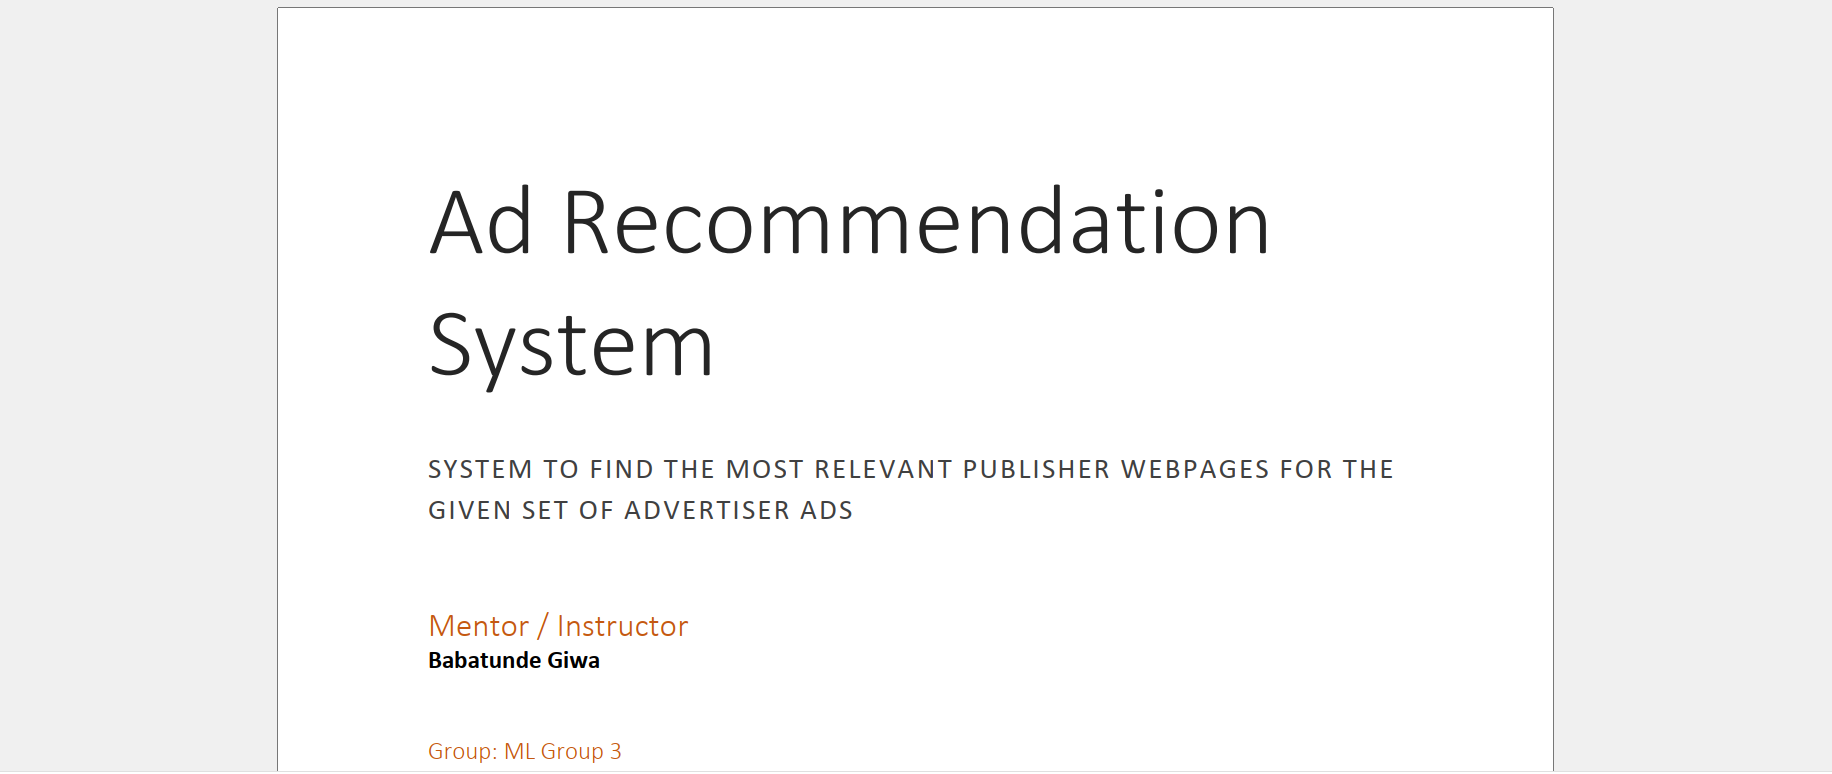

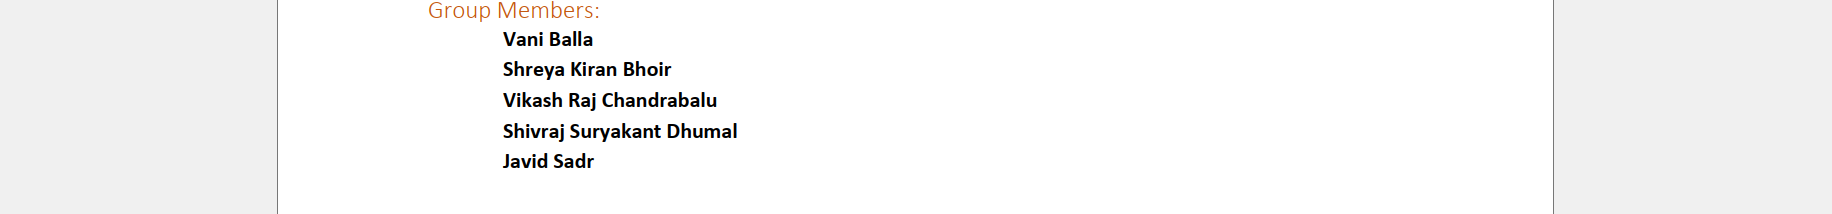

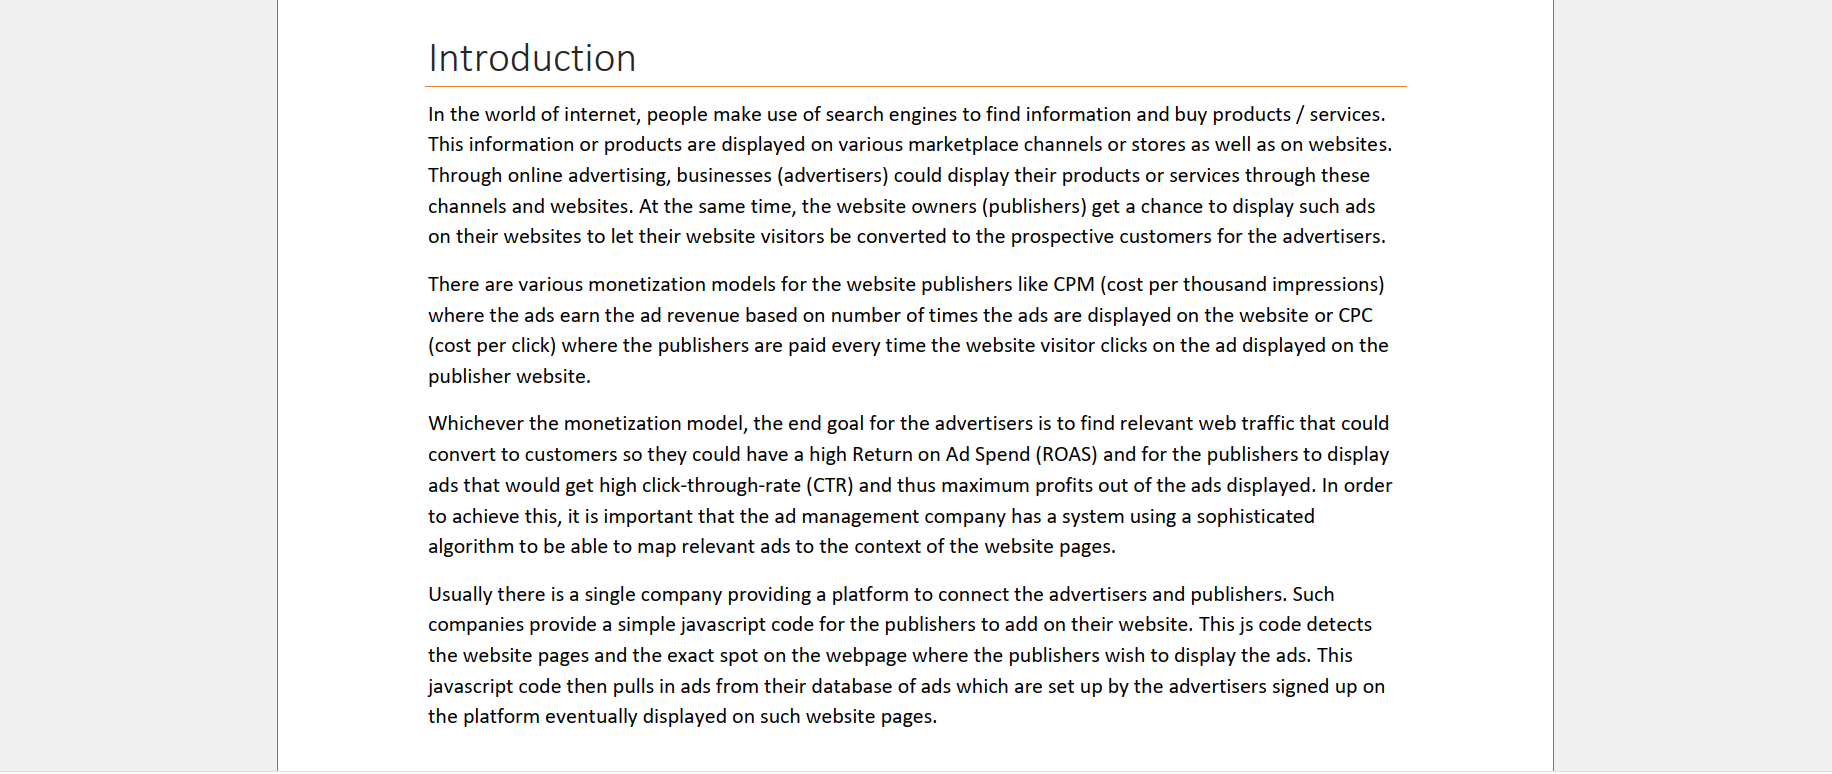

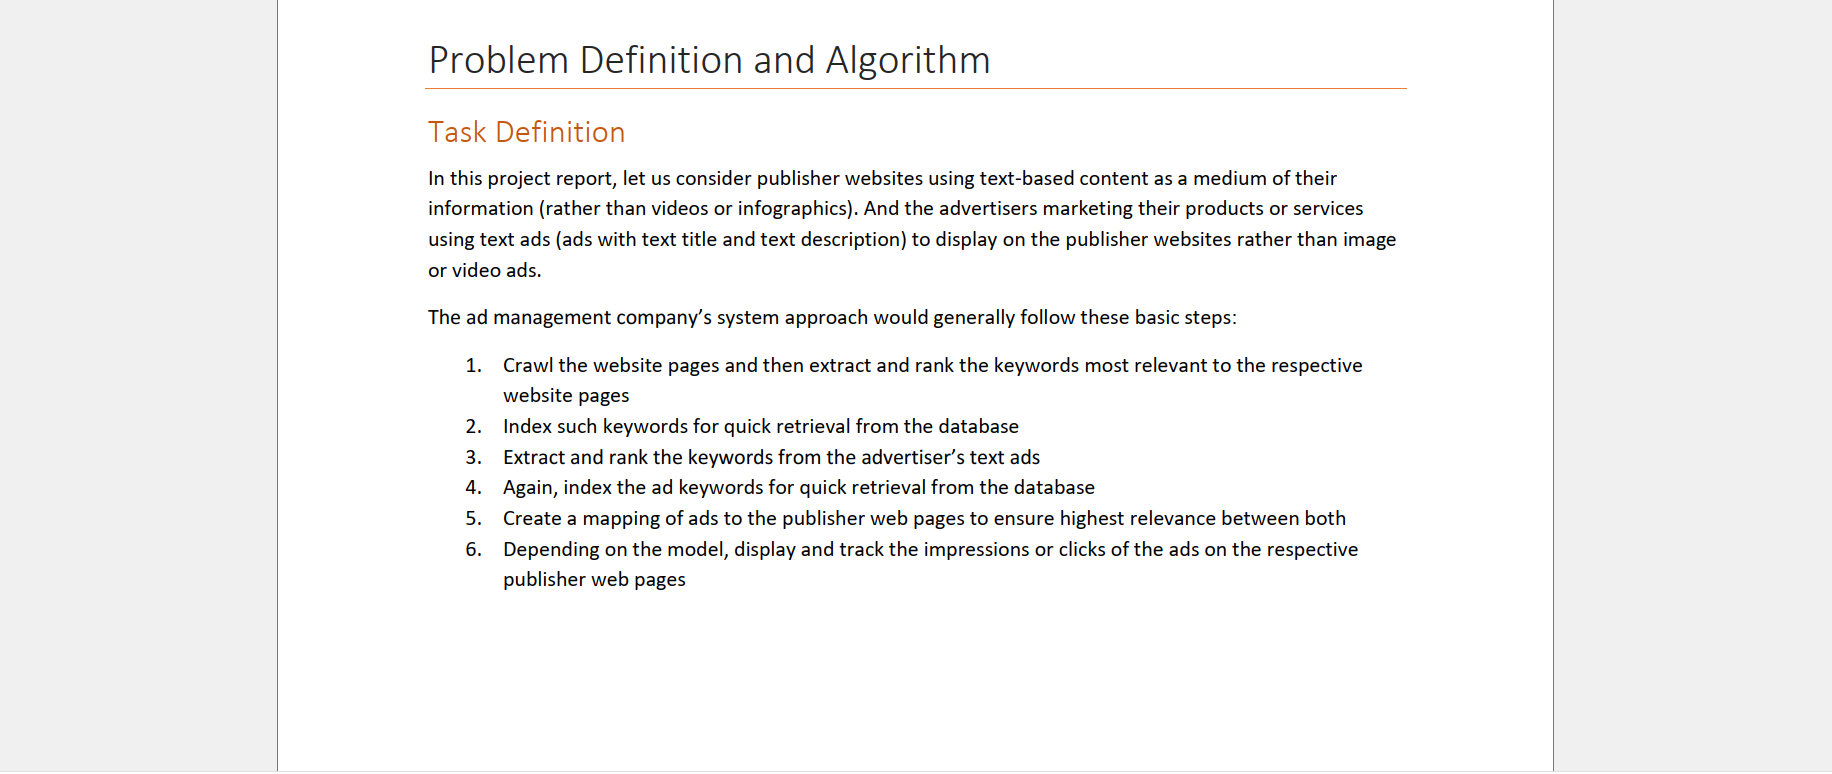

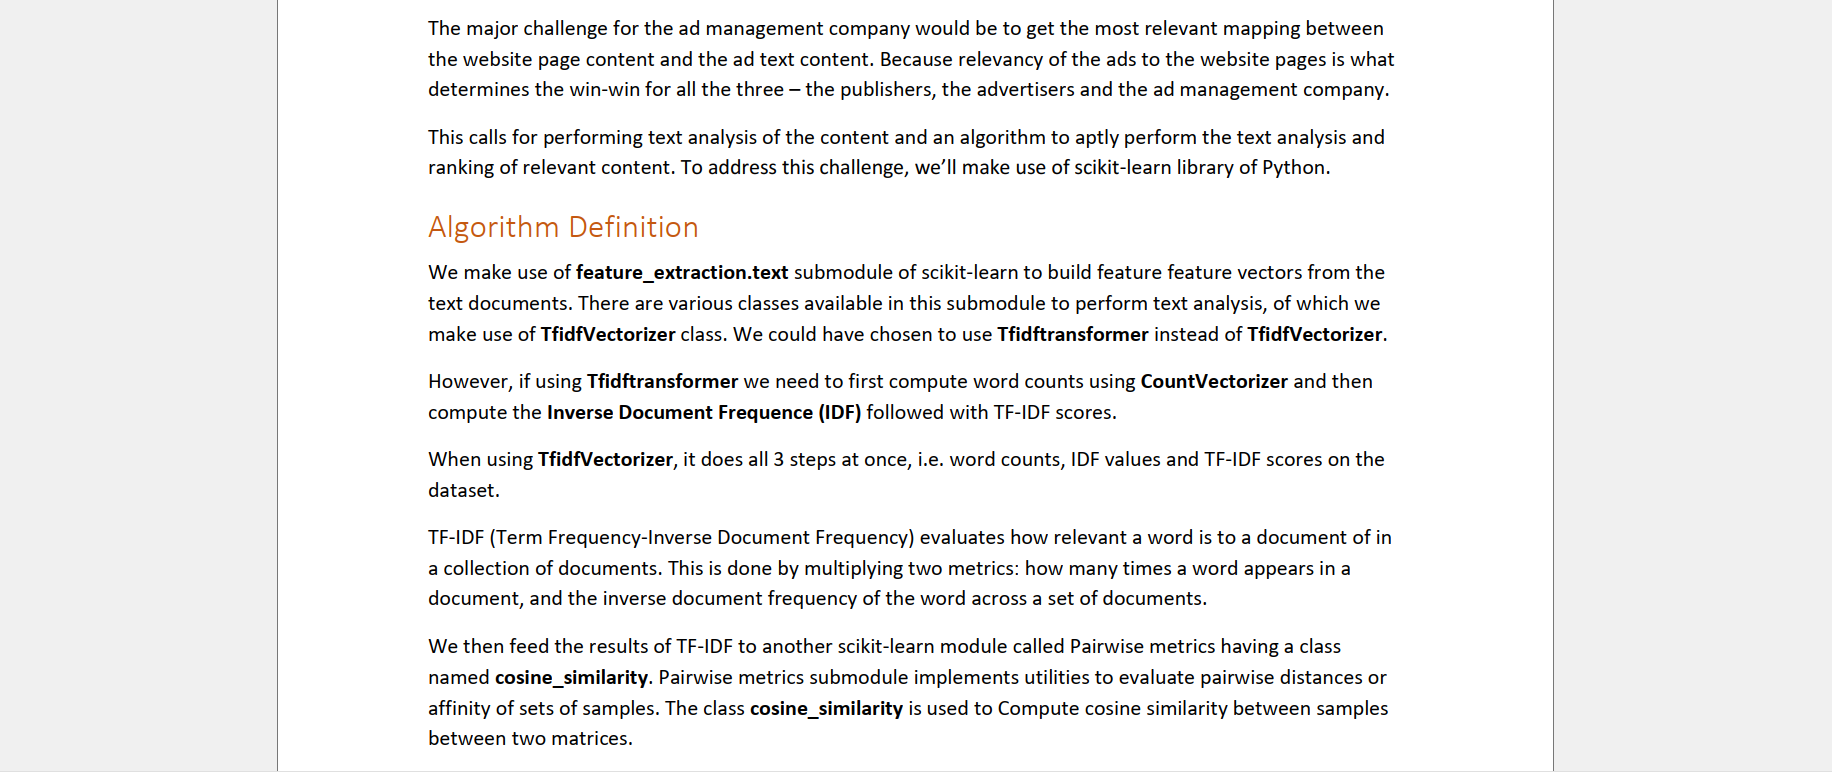

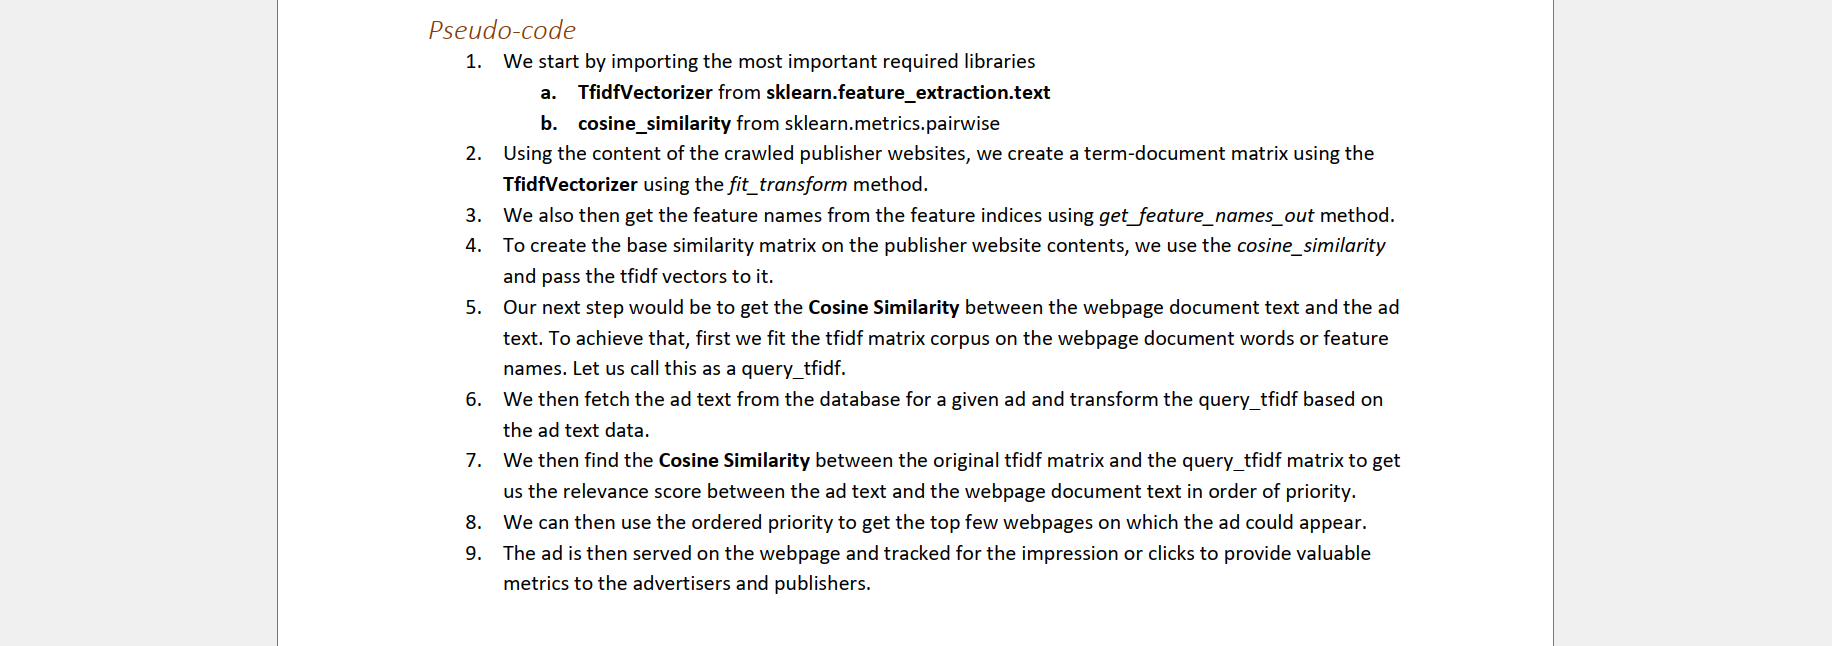

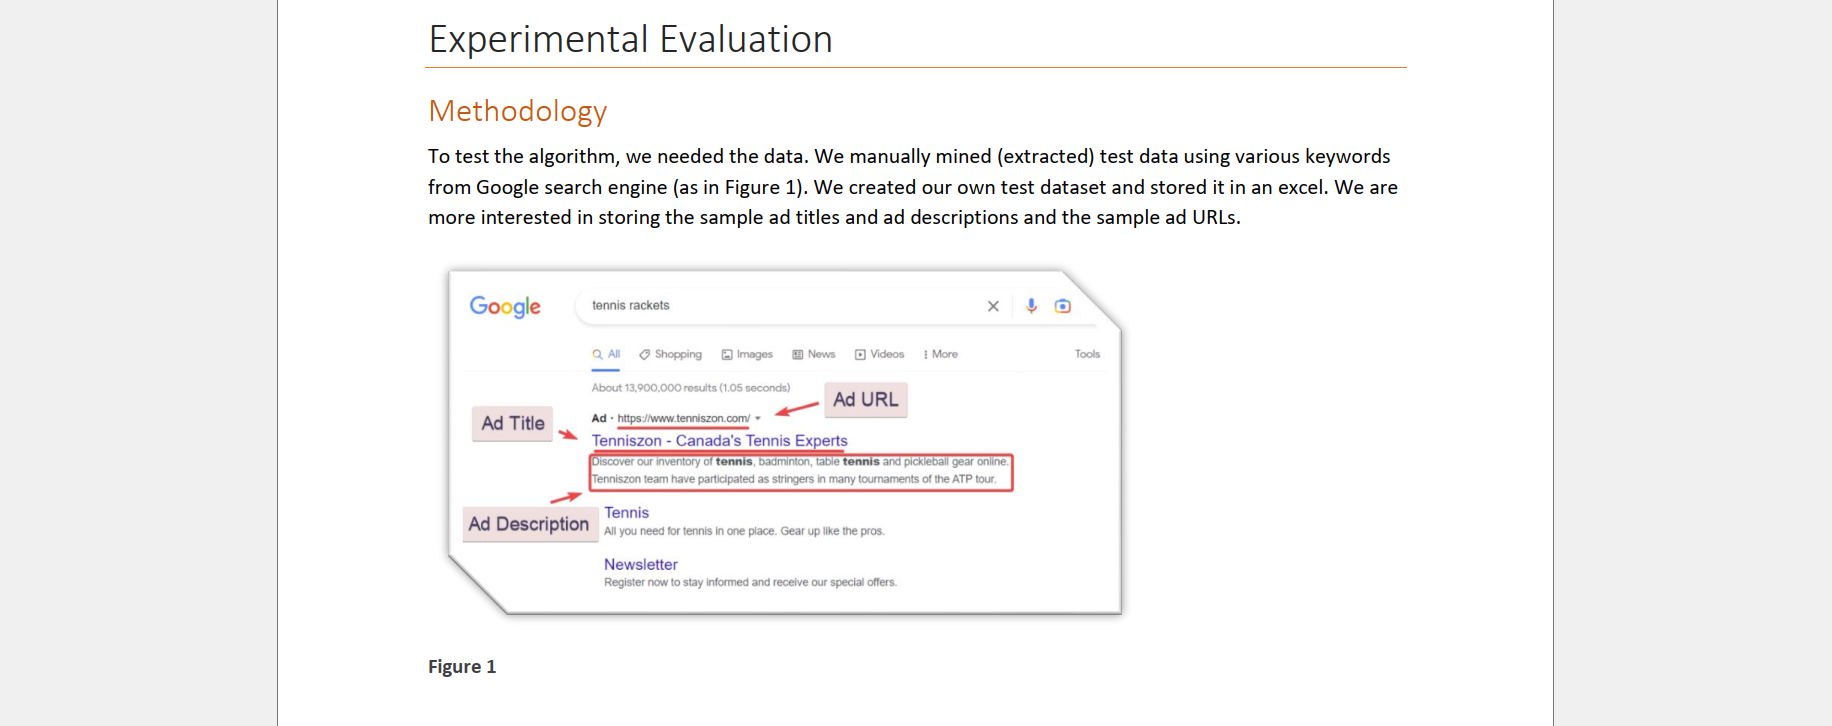

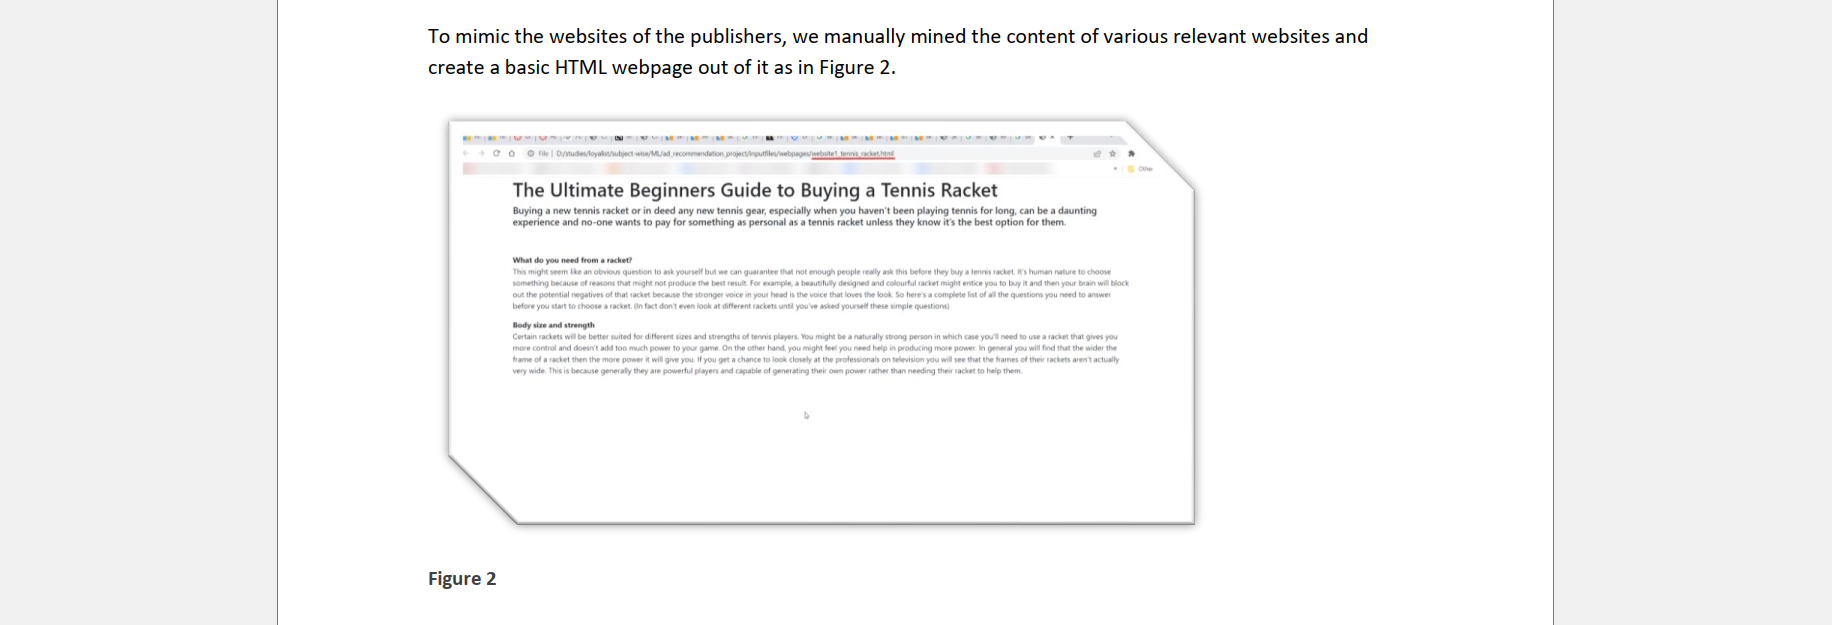

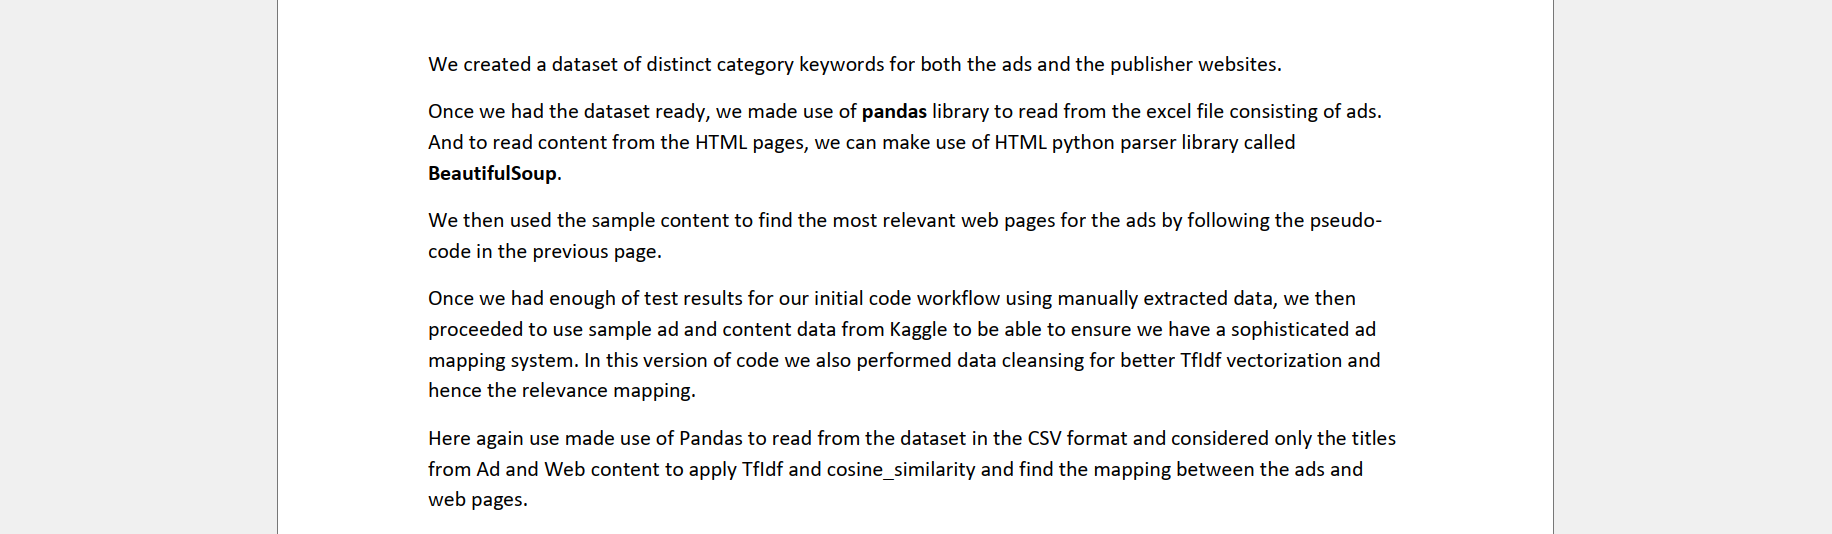

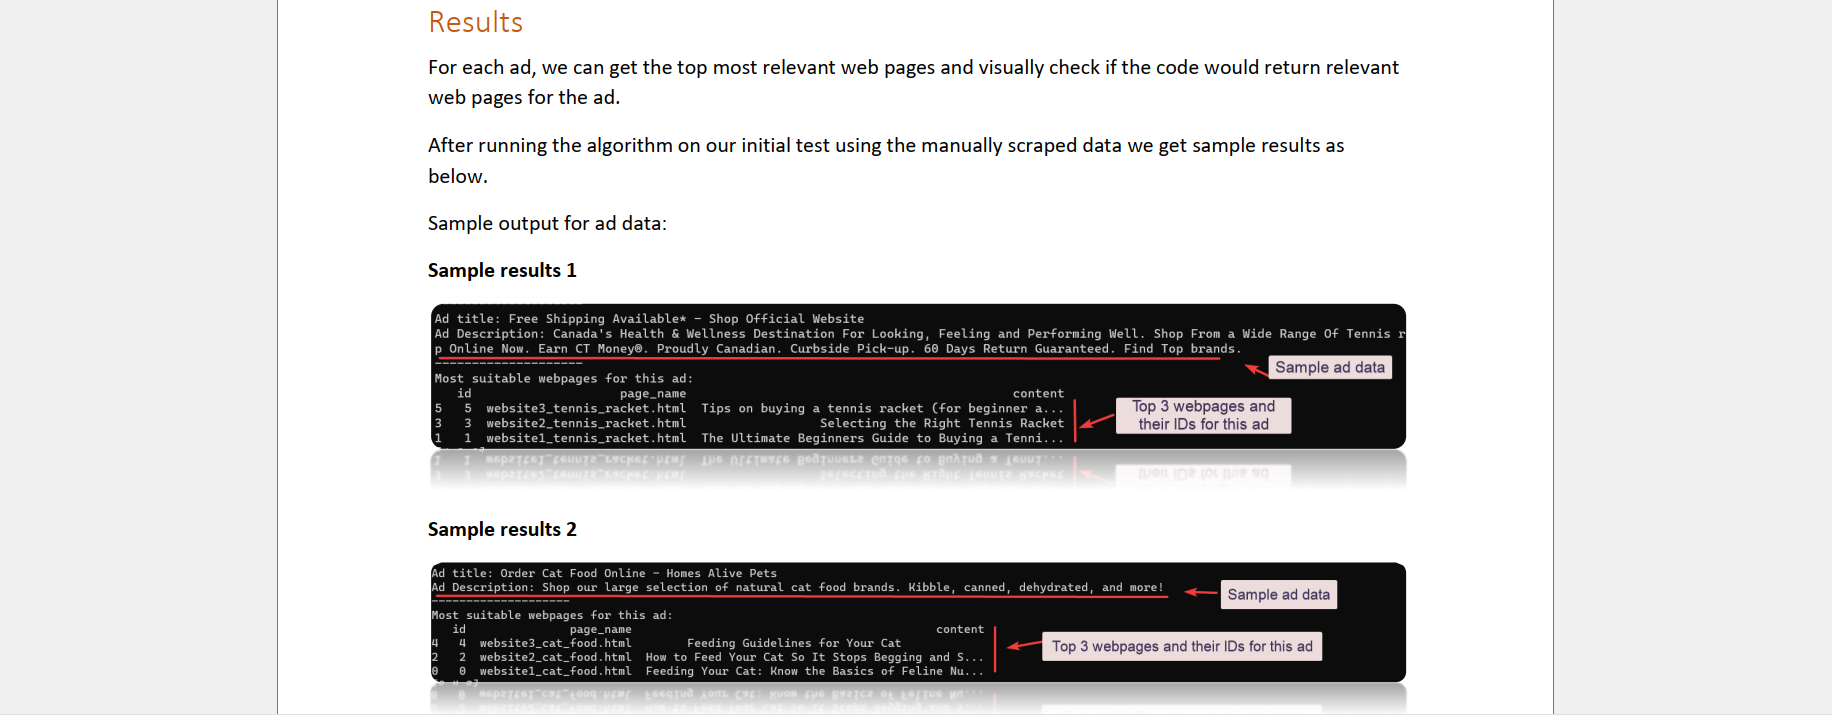

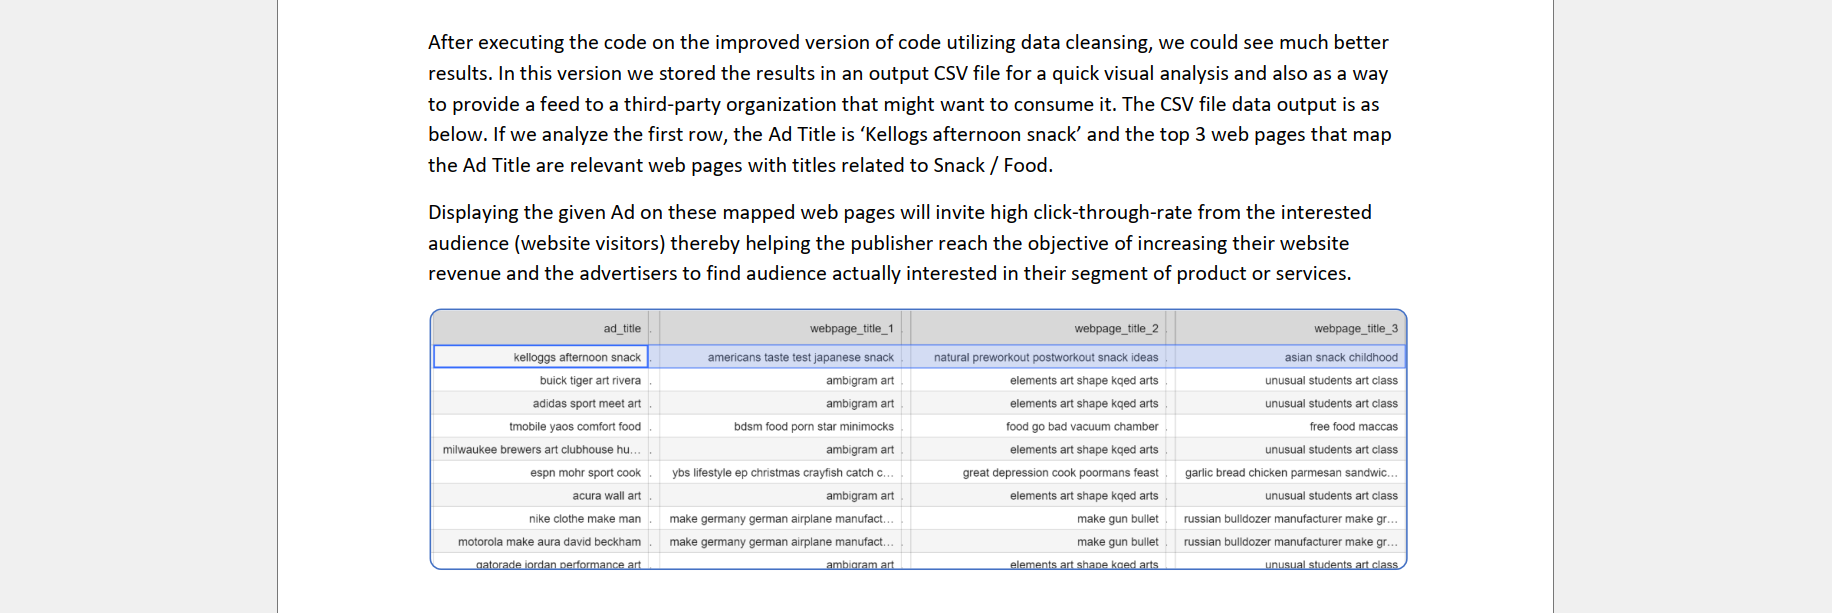

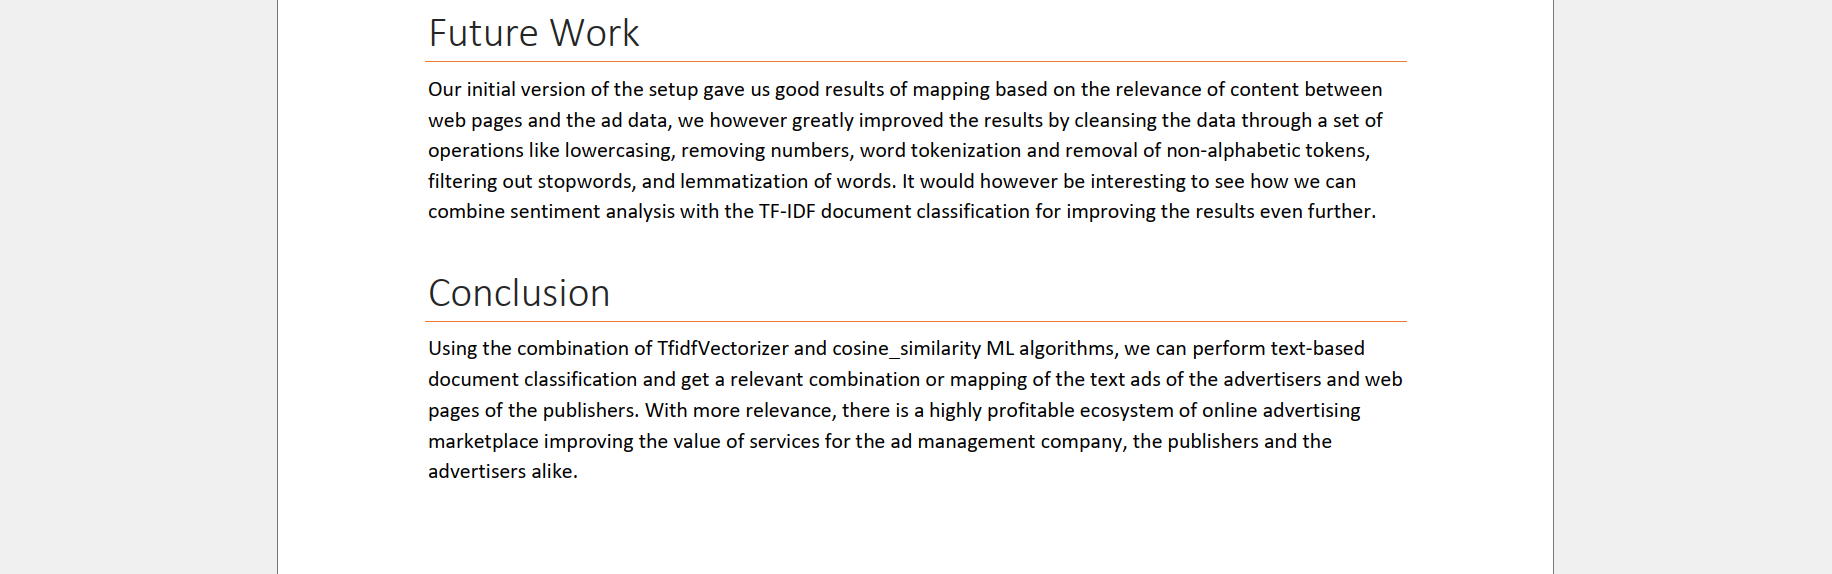

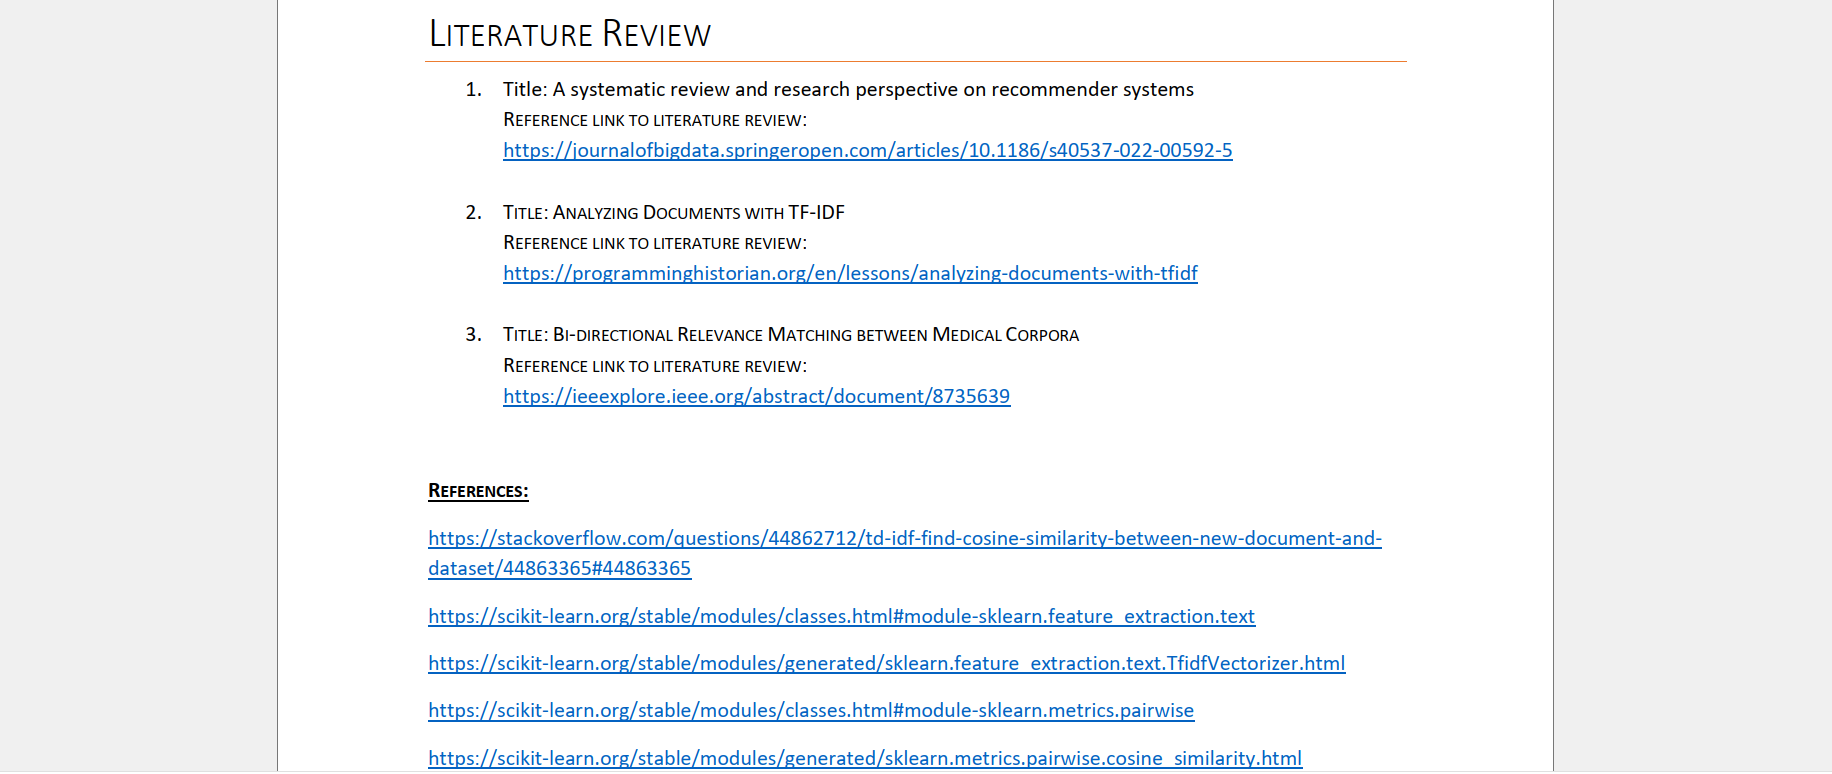

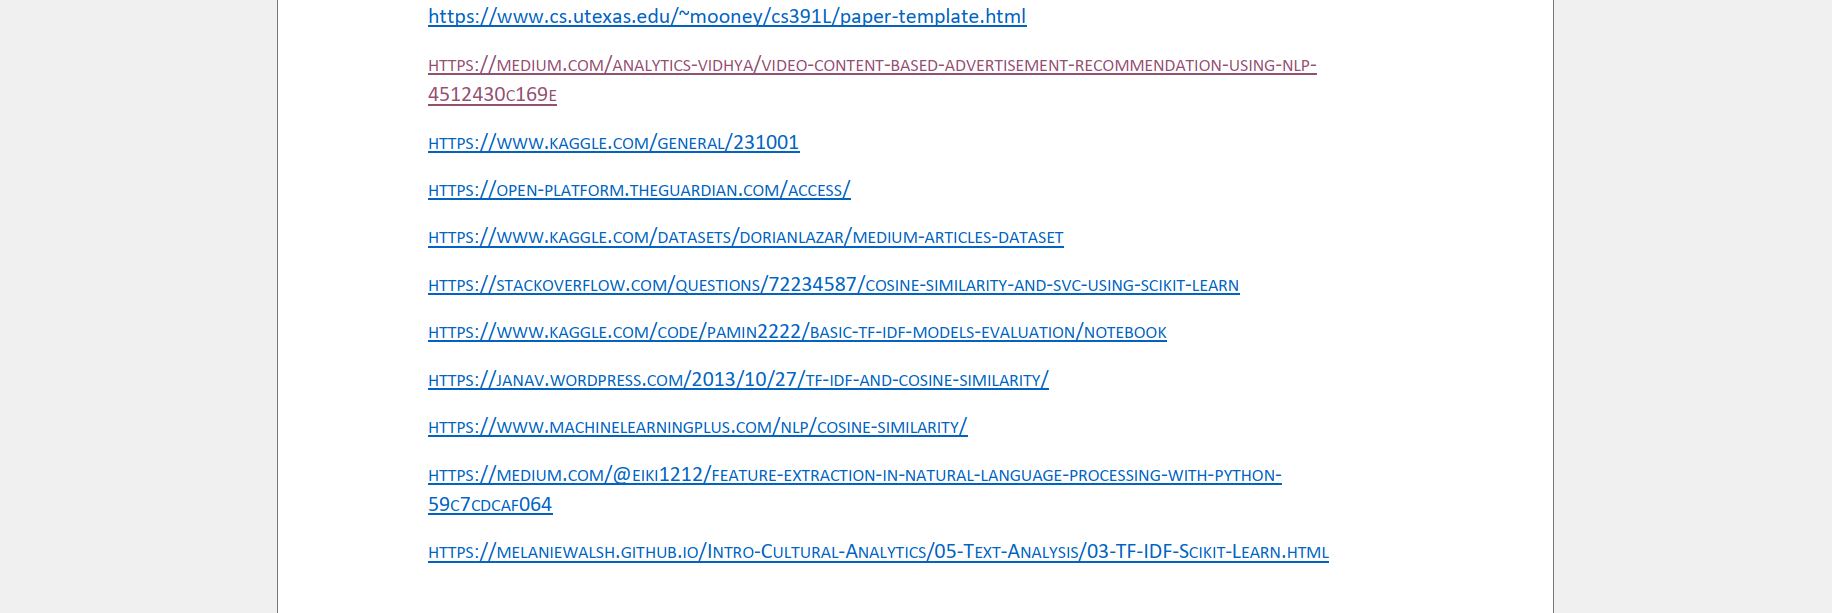

### Links to Literature Review

In [4]:
%%html
<a href="https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00592-5" target="_blank">https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00592-5</a><br>
<a href="https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf" target="_blank">https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf</a><br>
<a href="https://ieeexplore.ieee.org/abstract/document/8735639" target="_blank">https://ieeexplore.ieee.org/abstract/document/8735639</a><br>

### Reference Links

In [5]:
%%html
<a href="https://stackoverflow.com/questions/44862712/td-idf-find-cosine-similarity-between-new-document-and-dataset/44863365#44863365" target="_blank">https://stackoverflow.com/questions/44862712/td-idf-find-cosine-similarity-between-new-document-and-dataset/44863365#44863365</a><br>
<a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text" target="_blank">https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text</a><br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html" target="_blank">https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html</a><br>
<a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise" target="_blank">https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise</a><br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html" target="_blank">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html</a><br>
<a href="https://www.cs.utexas.edu/~mooney/cs391L/paper-template.html" target="_blank">https://www.cs.utexas.edu/~mooney/cs391L/paper-template.html</a><br>
<a href="HTTPS://MEDIUM.COM/ANALYTICS-VIDHYA/VIDEO-CONTENT-BASED-ADVERTISEMENT-RECOMMENDATION-USING-NLP-4512430C169E" target="_blank">HTTPS://MEDIUM.COM/ANALYTICS-VIDHYA/VIDEO-CONTENT-BASED-ADVERTISEMENT-RECOMMENDATION-USING-NLP-4512430C169E</a><br>
<a href="HTTPS://WWW.KAGGLE.COM/GENERAL/231001" target="_blank">HTTPS://WWW.KAGGLE.COM/GENERAL/231001</a><br>
<a href="HTTPS://OPEN-PLATFORM.THEGUARDIAN.COM/ACCESS/" target="_blank">HTTPS://OPEN-PLATFORM.THEGUARDIAN.COM/ACCESS/</a><br>
<a href="HTTPS://WWW.KAGGLE.COM/DATASETS/DORIANLAZAR/MEDIUM-ARTICLES-DATASET" target="_blank">HTTPS://WWW.KAGGLE.COM/DATASETS/DORIANLAZAR/MEDIUM-ARTICLES-DATASET</a><br>
<a href="HTTPS://STACKOVERFLOW.COM/QUESTIONS/72234587/COSINE-SIMILARITY-AND-SVC-USING-SCIKIT-LEARN" target="_blank">HTTPS://STACKOVERFLOW.COM/QUESTIONS/72234587/COSINE-SIMILARITY-AND-SVC-USING-SCIKIT-LEARN</a><br>
<a href="HTTPS://WWW.KAGGLE.COM/CODE/PAMIN2222/BASIC-TF-IDF-MODELS-EVALUATION/NOTEBOOK" target="_blank">HTTPS://WWW.KAGGLE.COM/CODE/PAMIN2222/BASIC-TF-IDF-MODELS-EVALUATION/NOTEBOOK</a><br>
<a href="HTTPS://JANAV.WORDPRESS.COM/2013/10/27/TF-IDF-AND-COSINE-SIMILARITY/" target="_blank">HTTPS://JANAV.WORDPRESS.COM/2013/10/27/TF-IDF-AND-COSINE-SIMILARITY/</a><br>
<a href="HTTPS://WWW.MACHINELEARNINGPLUS.COM/NLP/COSINE-SIMILARITY/" target="_blank">HTTPS://WWW.MACHINELEARNINGPLUS.COM/NLP/COSINE-SIMILARITY/</a><br>
<a href="HTTPS://MEDIUM.COM/@EIKI1212/FEATURE-EXTRACTION-IN-NATURAL-LANGUAGE-PROCESSING-WITH-PYTHON-59C7CDCAF064" target="_blank">HTTPS://MEDIUM.COM/@EIKI1212/FEATURE-EXTRACTION-IN-NATURAL-LANGUAGE-PROCESSING-WITH-PYTHON-59C7CDCAF064</a><br>
<a href="HTTPS://MELANIEWALSH.GITHUB.IO/INTRO-CULTURAL-ANALYTICS/05-TEXT-ANALYSIS/03-TF-IDF-SCIKIT-LEARN.HTML" target="_blank">HTTPS://MELANIEWALSH.GITHUB.IO/INTRO-CULTURAL-ANALYTICS/05-TEXT-ANALYSIS/03-TF-IDF-SCIKIT-LEARN.HTML</a><br>
<a href="HTTPS://STUDYMACHINELEARNING.COM/COSINE-SIMILARITY-TEXT-SIMILARITY-METRIC/" target="_blank">HTTPS://STUDYMACHINELEARNING.COM/COSINE-SIMILARITY-TEXT-SIMILARITY-METRIC/</a><br>